In [1]:
# pls install PySinga before running the code
from singa import tensor
from singa import device
from singa import optimizer
from singa import loss
from singa import layer
from singa import initializer
from singa.proto.model_pb2 import kTrain
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline



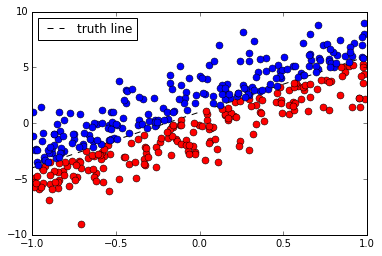

In [2]:

# generate the boundary
f = lambda x: (5 * x + 1)
x_tr = np.linspace(-1., 1, 200)
y_tr = f(x_tr)


# generate the training data
x = np.random.uniform(-1, 1, 400)
y = f(x) + 2 * np.random.randn(len(x))


# convert training data to 2d space
dat = np.array([[a,b] for (a, b) in zip(x, y)], dtype=np.float32)
label = []
posx, posy = [], []
negx, negy = [], []
for (a, b) in zip(x, y):    
    if 5.0 * a + 1.0 < b:
        l = 0
        negx.append(a)
        negy.append(b)
    else:
        l = 1
        posx.append(a)
        posy.append(b)
    label.append(l)
    
label = np.asarray(label, dtype=np.int32)

#plot the training data and the boundary
plt.plot(x_tr, y_tr, '--k', label='truth line')
plt.legend(loc='best')
plt.plot(posx, posy, 'ro', ms=7)
plt.plot(negx, negy, 'bo', ms=7)



In [3]:


tdat = tensor.from_numpy(dat)
tlbl = tensor.from_numpy(label)
# create layers
layer.engine = 'singacpp'
dense = layer.Dense('dense', 2, input_sample_shape=(2,))
p = dense.param_values()
print p[0].shape, p[1].shape

# init parameters
p[0].gaussian(0, 0.1)
p[1].set_value(0)

# setup optimizer and loss func
opt = optimizer.SGD(lr=0.03)
lossfunc = loss.SoftmaxCrossEntropy()



(2L, 2L) (2L,)


0.704925477505
0.466226756573
0.39766433835
0.352448284626
0.320274919271
0.296036958694


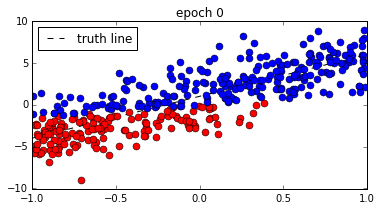

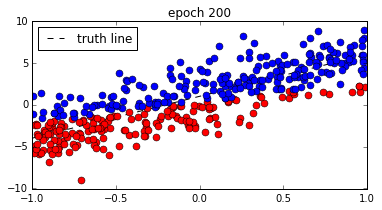

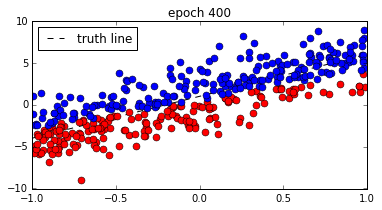

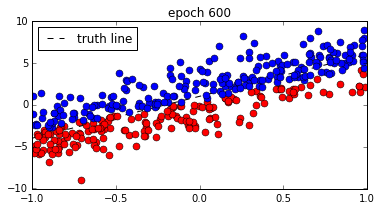

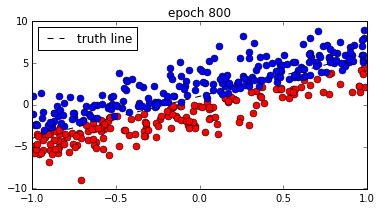

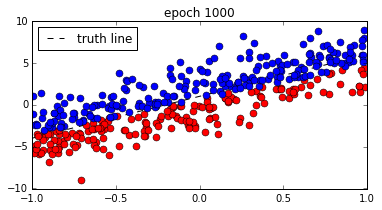

In [4]:

# plot the classification results using the current model parameters
def plot_status(w, b, title='origin'):
    global x_tr, y_tr, x, y
    posx, posy = [],[]
    negx, negy = [],[]
    dat = np.array([[xx, yy] for (xx, yy) in zip(x, y)])
    pr = np.add(np.dot(dat,w), b)
    for i in range(pr.shape[0]):
        if pr[i, 0] > pr[i,1]:
            negx.append(dat[i,0])
            negy.append(dat[i,1])
        else:
            posx.append(dat[i,0])
            posy.append(dat[i,1])
            
    plt.figure(figsize=(6,3));
    plt.plot(x_tr, y_tr, '--k', label='truth line')    
    plt.plot(posx, posy, 'ro', ms=7)
    plt.plot(negx, negy, 'bo', ms=7)
    plt.legend(loc='best')
    plt.title(title)
    plt.xlim(-1, 1);
    plt.ylim(y.min()-1, y.max()+1);
# sgd
for i in range(1001):
    act = dense.forward(kTrain, tdat)
    lvalue = lossfunc.forward(kTrain, act, tlbl)
    dact = lossfunc.backward()
    dact /= tdat.shape[0]
    _, dp = dense.backward(kTrain, dact)

    opt.apply(i, dp[0], p[0], 'w')
    opt.apply(i, dp[1], p[1], 'b')
    if (i%200 == 0):
        print lvalue.l1()
        plot_status(tensor.to_numpy(p[0]), tensor.to_numpy(p[1]),title='epoch %d' % i)

#train(dat, label)